In [1]:
import sys 
import os
sys.path.append(os.path.relpath("../../src/"))
from network import * # my class

import numpy as np
import networkx as nx
import pylab as plt
from scipy.stats import norm,uniform,binom,poisson
import random
from functools import reduce
from collections import deque
import itertools
from uuid import uuid4

import json 
from tqdm import tqdm

In [2]:
with open('clean_metro_data.json', 'r') as fp: # Load path for top 10 song data for each artist in our dataset
    line_dict = json.load(fp)
    line_dict = {int(key): value for key, value in line_dict.items()}

In [3]:
end_nodes = {}
complete_lines = {}
for k in range(1,11):
    complete_lines[k] = []
    end_nodes[k] = []
    for i , j in enumerate(line_dict[k]):
        if (i == 0 or i == len(line_dict[k])-1) and not j[1]:
            end_nodes[k].append((k,i,1,line_dict[k][i][0]))
        if j[1]:
            if j[1][0] >= k:
                complete_lines[k].append((k,i,1,line_dict[k][i][0]))
                if i == 0 or i == len(line_dict[k])-1:
                    end_nodes[k].append((k,i,1,line_dict[k][i][0]))
            else:
                val = reduce(lambda x,y : x if x[0] == j[0] else y,line_dict[j[1][0]])
                complete_lines[k].append((j[1][0],line_dict[j[1][0]].index(val),1,line_dict[k][i][0]))
                if i == 0 or i == len(line_dict[k])-1:
                    end_nodes[k].append((j[1][0],line_dict[j[1][0]].index(val),1,line_dict[k][i][0]))
        else:
            complete_lines[k].append((k,i,1,line_dict[k][i][0]))


shortened_lines = {}
for k in range(1,11):
    shortened_lines[k] = []
    count = 0
    for i,j in enumerate(line_dict[k]):
        if j[1] or i == 0 or i == len(line_dict[k])-1:
            if j[1]:
                if j[1][0] >= k:
                    shortened_lines[k].append((k,i,count,line_dict[k][i][0]))
                else:
                    val = reduce(lambda x,y : x if x[0] == j[0] else y,line_dict[j[1][0]])
                    shortened_lines[k].append((j[1][0],line_dict[j[1][0]].index(val),count,line_dict[k][i][0]))
            else:
                shortened_lines[k].append((k,i,count,line_dict[k][i][0]))
            count = 0
        count += 1 

In [4]:
nodes = []
node_locs = []
edges = []
visited_nodes = {}
node_to_name = {}
name_to_node = {}
dist = lambda x : Node.dist(x.node1,x.node2)
for i in range(1,11):
    path = complete_lines[i]
    for j in range(len(path)-1):
        loc1 = (path[j][0],path[j][1])
        if loc1 not in node_locs:
            node1 = Node.make(*loc1,name = path[j][3])
            node_locs.append(loc1)
            nodes.append(node1)
            node_to_name[node1.id] = path[j][3]
            name_to_node[path[j][3]] = node1.id
        else: 
            station = node_locs.index(loc1)
            node1 = nodes[station]
        loc2 = (path[j+1][0],path[j+1][1])
        if loc2 not in node_locs:
            node2 = Node.make(*loc2,name = path[j+1][3])
            node_locs.append(loc2)
            nodes.append(node2)
            node_to_name[node2.id] = path[j+1][3]
            name_to_node[path[j+1][3]] = node2.id
        else:
            station = node_locs.index(loc2)
            node2 = nodes[station]
        edges.append(Edge.make(node1,node2,weight = lambda x : dist(x)))


complete_network = Network(nodes,edges)
end_nodes_complete = {key : list(map(lambda x: complete_network._node_loc[(x[0],x[1])], value)) for key,value in end_nodes.items()}

nodes = []
node_locs = []
edges = []
visited_nodes = {}

for i in range(1,11):
    path = shortened_lines[i]
    for j in range(len(path)-1):
        loc1 = (path[j][0],path[j][1])
        if loc1 not in node_locs:
            node1 = Node.make(*loc1)
            node1.name = path[j][3]
            node_locs.append(loc1)
            nodes.append(node1)
        else: 
            station = node_locs.index(loc1)
            node1 = nodes[station]
        loc2 = (path[j+1][0],path[j+1][1])
        if loc2 not in node_locs:
            node2 = Node.make(*loc2)
            node2.name = path[j+1][3]
            node_locs.append(loc2)
            nodes.append(node2)
        else:
            station = node_locs.index(loc2)
            node2 = nodes[station]
        edge = Edge.make(node1,node2,weight = lambda x : dist(x))
        edge.target_weight = path[j+1][2]
        edges.append(edge)
        
shortened_network = Network(nodes,edges)
end_nodes_shortened = {key : list(map(lambda x: shortened_network._node_loc[(x[0],x[1])], value)) for key,value in end_nodes.items()}
end_nodes = {key : list(map(lambda x : x[-1], value)) for key,value in end_nodes.items()}

In [5]:
with open('end_stations.json', 'w') as fp: # write clean file
    json.dump(end_nodes,fp)

{1: ['pinar de chamartin', 'valdecarros'],
 2: ['las rosas', 'cuatro caminos'],
 3: ['moncloa', 'villaverde alto'],
 4: ['arguelles', 'pinar de chamartin'],
 5: ['casa de campo', 'alameda de osuna'],
 6: ['laguna', 'carpetana'],
 7: ['pitis', 'hospital del henares'],
 8: ['aeropuerto t4', 'nuevos ministerios'],
 9: ['paco de lucia', 'arganda del rey'],
 10: ['puerta del sur', 'hospital infanta sofia']}

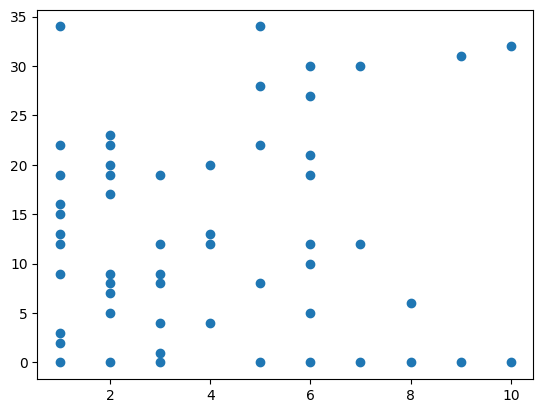

In [6]:
plt.scatter([i.loc[0] for i in shortened_network.nodes], [i.loc[1] for i in shortened_network.nodes])

In [7]:
edge_ids = [(i.id, i.weight) for i in shortened_network.edges]
target_weights = {i[0]: 1 for i in edge_ids}

In [8]:
def error(network):
    error_vector = [(i.weight - i.target_weight)**2 for i in network.edges]
    average_error = sum(error_vector)/len(error_vector)
    return average_error**0.5
dirs = {1:(1,0), 2:(0,1), 3:(-1,0), 4:(0,-1)}
node_memory = {node.id : {'cycle' : itertools.cycle(dirs.values()),
                          'back_counter' : 0} for node in shortened_network.nodes}

def cardinal_move(node,eps,weight):
    if node_memory[node.id]['back_counter'] > 100:
        return 'stuck'
    dir = next(node_memory[node.id]['cycle'])
    node.move(eps * dir[0], eps * dir[1], True)
    new_weight = error(shortened_network)
    if new_weight > weight:
        node.move(-eps * dir[0],- eps * dir[1], True)
        node_memory[node.id]['back_counter'] += 1
    else:
        node_memory[node.id]['back_counter'] = 0

In [10]:
# x = (lon + 180) * (100 / 360)
# y = (100 / pi) * ln(tan(pi/4 + lat/2))

In [11]:
pile = shortened_network.nodes[:]

for i in tqdm(range(100)):
    for node in pile:

        x = cardinal_move(node,0.02,error(shortened_network))
        if x == 'stuck':
            pile.remove(node)
            break

100%|██████████| 100/100 [00:01<00:00, 51.72it/s]


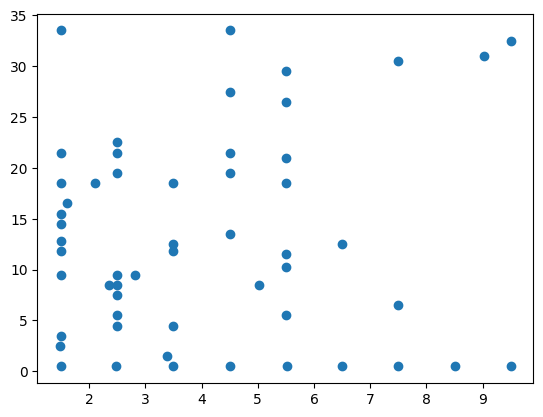

In [12]:
plt.scatter([i.loc[0] for i in shortened_network.nodes], [i.loc[1] for i in shortened_network.nodes])